The scripts should be run in order.
<br> Currently you are on 
<br>&emsp;&emsp;resume.ipynb
<br>&ensp;->&nbsp;job_selection.ipynb
<br>&emsp;&emsp;job_vectorise.ipynb

This script follows on from resume.ipynb.
<br>The dataframe has been saved as a pickle file and is retreived

In [15]:
import pandas as pd
import os, glob, re
from glob import glob
from bs4 import BeautifulSoup
import logging, importlib, sys, tqdm
import spacy
import pickle
from spacy.lang.en import English
from spacy.lang.en.stop_words import STOP_WORDS
from sklearn.feature_extraction.text import CountVectorizer
from _pckle import save_pickle_object, load_pickle_object
from _logging import set_logging
from _save_file import save_file
from _graph import histplot_count, histplot_range_count
from _utility import gl

set_logging(logging)
df_jobs = load_pickle_object(gl.pkl_df_jobs_file)


2022-12-27 19:56:38,464 | INFO : Loading pickle file from: pickle\pkl_df_jobs.pkl


Find out from the similarity cosine scores distribution which job descriptions
are likely to be relevant for the resume

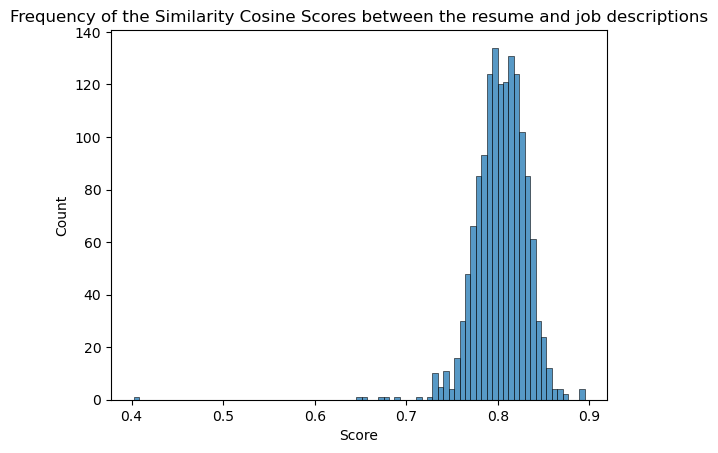

In [16]:
title = "Frequency of the Similarity Cosine Scores between the resume and job descriptions"
histplot_count(title, df_jobs, gl.score)

Need a closer look at the range between 0.7 and 0.9

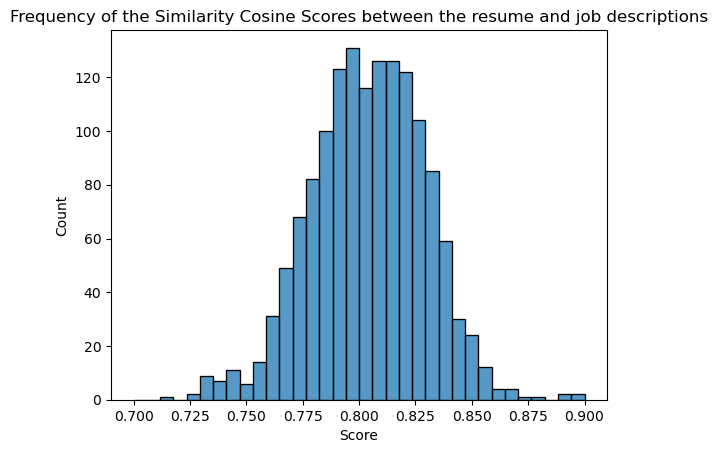

In [17]:
title = "Frequency of the Similarity Cosine Scores between the resume and job descriptions"
histplot_range_count(title, df_jobs, gl.score, (0.7, 0.9))

It looks like a good threshold for removing non data science jobs is around 0.78.
<br>Experiment with different score ranges to find out where data science jobs are being selected

In [18]:
def get_scores_for_job_descriptions(df_jobs, lower_limit, upper_limit):
    df_temp = df_jobs.sort_values(gl.score)
    df_temp1 = df_temp[df_temp[gl.score].between(lower_limit, upper_limit)]
    return df_temp1

In [19]:
lower_limit = 0.40
upper_limit = 0.75
print(f"Job titles for scores between {lower_limit} and {upper_limit}")
df_temp = get_scores_for_job_descriptions(df_jobs, lower_limit, upper_limit)
print("ID\tScore\tTitle")
for i, item in enumerate(df_temp.values):
    if i > 10 and i < (len(df_temp) - 10):
        continue
    print(f"{item[0]}\t {round(item[4], 2)}\t {item[1]}")



Job titles for scores between 0.4 and 0.75
ID	Score	Title
861	 0.4	 Page Not Found - Indeed Mobile
35	 0.65	 Director of Econometric Modeling - External Careers
570	 0.65	 Machine Learning Engineer - San Francisco, CA
1292	 0.67	 Biostatistician I - United States
94	 0.68	 Senior/Staff Data Scientist - San Francisco, CA
440	 0.69	 Blockchain Analyst - Portland, OR
733	 0.71	 Director of Language Engineering - Seattle, WA 98104
541	 0.73	 Direct Care - All Experience Levels (CNA, HHA, PCA Welcome) - Norwell, MA 02061
387	 0.73	 Entry Level Accenture Consulting Development Program Analyst - San Francisco, CA 94105
1169	 0.73	 Product Specialist Intern - Menlo Park, CA
864	 0.73	 Senior Backend Engineer - San Francisco, CA 94107
1261	 0.74	 Data Scientist - United States
335	 0.74	 Data Scientist - New York, NY
14	 0.74	 Senior Data Scientist - Sunnyvale, CA 94089
63	 0.74	 Production Analyst - Camarillo, CA
204	 0.74	 Data Scientist - San Francisco, CA
1386	 0.75	 Lead Data Scientist - R

Even for low scores we are retreiving data science jobs. But it may be the case that these job descriptions do not make a good match for the resume.
<br>Lets look at the body for job titles

In [20]:
def get_body(df_temp, id):
    row = df_temp[df_temp[gl.id] == id]
    body = row[gl.body].values[0]
    return body

In [21]:
#IDs = [570, 1261, 335]
id = 570
body = get_body(df_temp, id)
logging.info(f"Id = {id}, body = ")
logging.info(body)

2022-12-27 19:56:40,642 | INFO : Id = 570, body = 
2022-12-27 19:56:40,646 | INFO : Machine Learning Engineer - San Francisco, CA 
*****************************************************
Help the world spend their time with intention.
*****************************************************

Ping builds automation tools for professional services. We're starting by automating timekeeping for the world's largest enterprises and then using that data to transform the way these industries price, operate and work. Professionals won't just use our system to manage their time but to create it.

And we need your help.

****************
Our Vision
****************

We believe that time is the most valuable thing we can spend. We also believe that professionals are wasting a staggering amount of time at work because they have no idea where they are spending it. Previously, professionals had to manually record every six-minutes of their day into antiquated timekeeping software. We are automating this w

In [22]:
id = 1261
body = get_body(df_temp, id)
logging.info(f"Id = {id}, body = ")
logging.info(body)

2022-12-27 19:56:40,673 | INFO : Id = 1261, body = 
2022-12-27 19:56:40,674 | INFO : Data Scientist - United States 
 Data Scientist 
US 
Nehemiah Security is in search of Mid to Senior level Data Scientist. The data scientist will be responsible for creating models that pertain to our customers’ vulnerability to cyber attack given technical details of how the customer’s technology infrastructure is set up; and models that pertain to how a customer’s business is financially exposed to an attacker exploiting those vulnerabilities. The Data Scientist will report to the Global Chief Technology Officer. 
 In order to make the models relevant to a specific customer, the successful candidate will have to work with data that considers the current cyber threat environment globally, the customer’s exposure to those threats (in terms of their technology infrastructure’s configuration) and the financial losses that those threats could cause. Since the models are of a range of possible attacks, co

In [23]:
id = 335
body = get_body(df_temp, id)
logging.info(f"Id = {id}, body = ")
logging.info(body)

2022-12-27 19:56:40,719 | INFO : Id = 335, body = 
2022-12-27 19:56:40,721 | INFO : Data Scientist - New York, NY 
A BIT ABOUT OUR DATA SCIENCE & ANALYTICS TEAM

Kinship's Data Science & Analytics team is core to our strategy. We're using digital, data and customer insights to transform our business by finding answers to problems that we've often never asked ourselves before. Our vast data assets are being combined to build a 360° view of Pets and Pet Owners to not only power Kinship's businesses but also influence the next great ideas in the Petcare space. This role will be key in helping us understand the power of our data, and how this translates into value for our company, Pets, and Pet Owners. Frequently the projects will be ambiguous, but that's part of the fun; you will determine the best way to leverage our data to tell the right story for any given audience.

HOW YOU'LL CREATE A BETTER WORLD FOR PETS


 Apply data science approaches to understand and predict pet and pet owner 

Summary statistics

In [24]:
def get_summary_statistics(df):
    get_perc = lambda x, y: round(len(x)/len(y)*100, 2)
    
    print(f"There are {len(df)} job descriptions")
    df_ = df[df.duplicated()]
    print(f"Of which {get_perc(df_, df_jobs)}% are duplicated")
    df_ = df[df[gl.title].str.contains(pat = 'Data Scie', case=False)]
    print(f"Of which {get_perc(df_, df_jobs)}% are specified as Data Science jobs in their job titles")
    df_ = df[df[gl.title].str.contains(pat = 'Computer Vision', case=False)]
    print(f"Of which {get_perc(df_, df_jobs)}% are specified as Computer Vision jobs in their job titles")
    re_pattern = re.compile(r'\b(?:natural language processing|NLP)(?<!\w\B)',re.IGNORECASE)
    df_ = df[df[gl.title].str.contains(pat = re_pattern, regex=True)]
    print(f"Of which {get_perc(df_, df_jobs)}% are specified as NLP jobs in their job titles")
    re_pattern = re.compile(r'\b(?:AI|A[.]I[.]|artificial)(?<!\w\B)',re.IGNORECASE)
    df_ = df[df[gl.title].str.contains(pat = re_pattern, regex=True)]
    print(f"Of which {get_perc(df_, df_jobs)}% are specified as AI jobs in their job titles")
    
    list_lookup = ['Python', 'years', 'experience', 'skills', 'Scikit-Learn', 'GeonamesCache',
        'Dimensionality', 'K-Means']
    for item in list_lookup:
        df_ = df[df[gl.bullet_points].str.contains(pat = item, case=False)]
        print(f"Of which {get_perc(df_, df_jobs)}% are specifying {item} in their bullet points")
    
    tot_no_bullet_points1 = df[gl.bullet_points].isnull().sum()
    tot_no_bullet_points2 = (df[gl.bullet_points] == '').sum()
    tot_no_bullet_points_perc = round((tot_no_bullet_points1 + tot_no_bullet_points2)/ len(df) * 100, 2)
    print(f"Of which {tot_no_bullet_points_perc}% do not have any bullet points")
    df_ = df[df[gl.body].str.contains(pat = 'Statistical Modelling', case=False)]
    print(f"Of which {get_perc(df_, df_jobs)}% are specifying Statistical Modelling in the job description")

In [25]:
print("Summary Statistics for all of the jobs")
print("--------------------------------------")
get_summary_statistics(df_jobs)


Summary Statistics for all of the jobs
--------------------------------------
There are 1458 job descriptions
Of which 0.0% are duplicated
Of which 35.67% are specified as Data Science jobs in their job titles
Of which 0.41% are specified as Computer Vision jobs in their job titles
Of which 4.12% are specified as NLP jobs in their job titles
Of which 1.58% are specified as AI jobs in their job titles
Of which 51.37% are specifying Python in their bullet points
Of which 55.14% are specifying years in their bullet points
Of which 81.21% are specifying experience in their bullet points
Of which 60.7% are specifying skills in their bullet points
Of which 11.73% are specifying Scikit-Learn in their bullet points
Of which 0.0% are specifying GeonamesCache in their bullet points
Of which 1.85% are specifying Dimensionality in their bullet points
Of which 3.16% are specifying K-Means in their bullet points
Of which 9.47% do not have any bullet points
Of which 0.48% are specifying Statistical M

Not all the job deescriptions are visible for each job, but from what we can see these job descriptions do notmatch well as expected with the original resume.
<br>Lets store the job descriptions with scores greater than 0.78 in a pickle file and continue onto the next script.

In [26]:
score_threshold = 0.78
df_selected_jobs = df_jobs.loc[df_jobs[gl.score] > score_threshold]
df_not_selected_jobs = df_jobs.loc[df_jobs[gl.score] <= score_threshold]
no_jobs = len(df_jobs)
no_selected_jobs = len(df_selected_jobs)
message = f"Number of job descriptions = {no_jobs}. After filtering there are {no_selected_jobs} left"
logging.info(message)
save_pickle_object(df_selected_jobs, gl.pkl_df_selected_jobs)
save_pickle_object(df_not_selected_jobs, gl.pkl_df_not_selected_jobs)

2022-12-27 19:56:41,182 | INFO : Number of job descriptions = 1458. After filtering there are 1204 left
2022-12-27 19:56:41,183 | INFO : Saving pickle file from: pickle\pkl_df_selected_jobs.pkl
2022-12-27 19:56:41,753 | INFO : Saving pickle file from: pickle\pkl_df_not_selected_jobs.pkl


In [27]:
print("Summary Statistics for Selected Jobs")
print("------------------------------------")
get_summary_statistics(df_selected_jobs)

Summary Statistics for Selected Jobs
------------------------------------
There are 1204 job descriptions
Of which 0.0% are duplicated
Of which 30.52% are specified as Data Science jobs in their job titles
Of which 0.41% are specified as Computer Vision jobs in their job titles
Of which 3.57% are specified as NLP jobs in their job titles
Of which 1.51% are specified as AI jobs in their job titles
Of which 43.76% are specifying Python in their bullet points
Of which 46.91% are specifying years in their bullet points
Of which 66.67% are specifying experience in their bullet points
Of which 50.0% are specifying skills in their bullet points
Of which 10.29% are specifying Scikit-Learn in their bullet points
Of which 0.0% are specifying GeonamesCache in their bullet points
Of which 1.85% are specifying Dimensionality in their bullet points
Of which 2.95% are specifying K-Means in their bullet points
Of which 10.55% do not have any bullet points
Of which 0.48% are specifying Statistical Mode

In [28]:
print("Summary Statistics for NOT Selected Jobs")
print("----------------------------------------")
get_summary_statistics(df_not_selected_jobs)

Summary Statistics for NOT Selected Jobs
----------------------------------------
There are 254 job descriptions
Of which 0.0% are duplicated
Of which 5.14% are specified as Data Science jobs in their job titles
Of which 0.0% are specified as Computer Vision jobs in their job titles
Of which 0.55% are specified as NLP jobs in their job titles
Of which 0.07% are specified as AI jobs in their job titles
Of which 7.61% are specifying Python in their bullet points
Of which 8.23% are specifying years in their bullet points
Of which 14.54% are specifying experience in their bullet points
Of which 10.7% are specifying skills in their bullet points
Of which 1.44% are specifying Scikit-Learn in their bullet points
Of which 0.0% are specifying GeonamesCache in their bullet points
Of which 0.0% are specifying Dimensionality in their bullet points
Of which 0.21% are specifying K-Means in their bullet points
Of which 4.33% do not have any bullet points
Of which 0.0% are specifying Statistical Model